In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)
datagen.fit(x_train)

In [7]:
# Resize Fashion-MNIST images to 32x32
from tensorflow.image import resize
x_train = np.array([resize(img, (32, 32)).numpy() for img in x_train])
x_test = np.array([resize(img, (32, 32)).numpy() for img in x_test])

In [8]:
# Build Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = models.Sequential([
    layers.Conv2D(3, (3, 3), padding="same", input_shape=(32, 32, 1)),  # Convert grayscale to 3 channels
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

<ipython-input-8-d9a094452412>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile Model
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:
# Learning Rate Scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)

In [11]:
# Callbacks
checkpoint = ModelCheckpoint('best_fashion_mnist_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [12]:
# Train Model
batch_size = 128
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=30,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


468/468 ━━━━━━━━━━━━━━━━━━━━ 103s 127ms/step - accuracy: 0.5505 - loss: 8.9618 - val_accuracy: 0.1013 - val_loss: 4.2792 - learning_rate: 0.0010
Epoch 2/30
  1/468 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.7812 - loss: 1.1507

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7812 - loss: 1.1507 - val_accuracy: 0.1013 - val_loss: 4.8876 - learning_rate: 0.0010
Epoch 3/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.7895 - loss: 1.1373 - val_accuracy: 0.2942 - val_loss: 2.5200 - learning_rate: 0.0010
Epoch 4/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8281 - loss: 1.0746 - val_accuracy: 0.2842 - val_loss: 2.5775 - learning_rate: 0.0010
Epoch 5/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.8171 - loss: 1.0595 - val_accuracy: 0.6029 - val_loss: 1.6308 - learning_rate: 0.0010
Epoch 6/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8203 - loss: 1.0354 - val_accuracy: 0.5960 - val_loss: 1.6252 - learning_rate: 0.0010
Epoch 7/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8302 - loss: 1.0354 - val_accuracy: 0.7906 - val_loss: 1.1477 - learning_rate: 0.0010
Epoch 8/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8047 - loss: 0.9845 - val_a

In [13]:
# Evaluate Model
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9044 - loss: 0.7549


[0.7550390362739563, 0.9010000228881836]

In [14]:
# Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.90      0.83      0.87      1000
           3       0.93      0.83      0.87      1000
           4       0.82      0.88      0.85      1000
           5       0.97      0.99      0.98      1000
           6       0.68      0.76      0.72      1000
           7       0.96      0.96      0.96      1000
           8       0.96      0.99      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [15]:
# Save Model
model.save("fashion_mnist_model.keras")

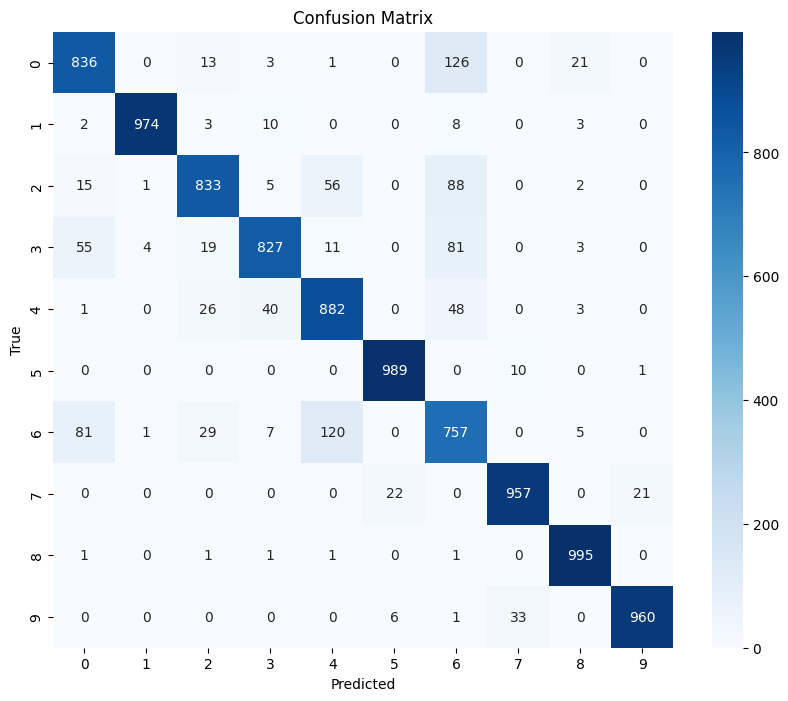

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
plt.show()

In [17]:
# Accuracy and Loss Plots
epochs = range(1, len(history.history['accuracy']) + 1)

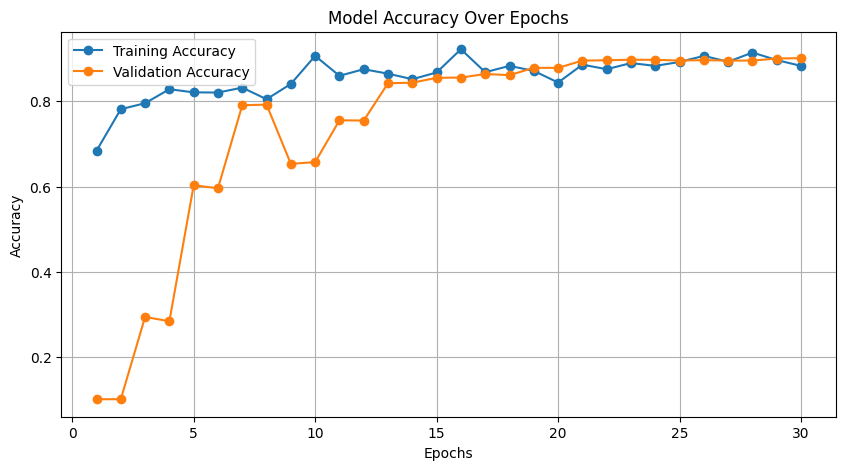

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("accuracy_plot.png")
plt.show()

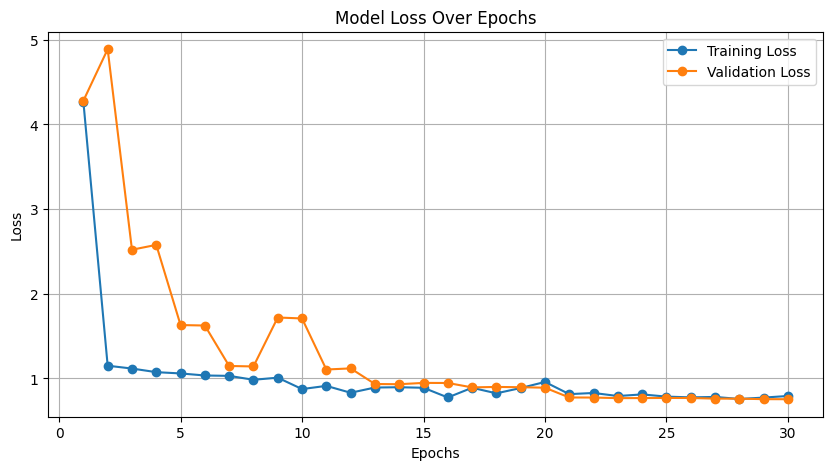

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()

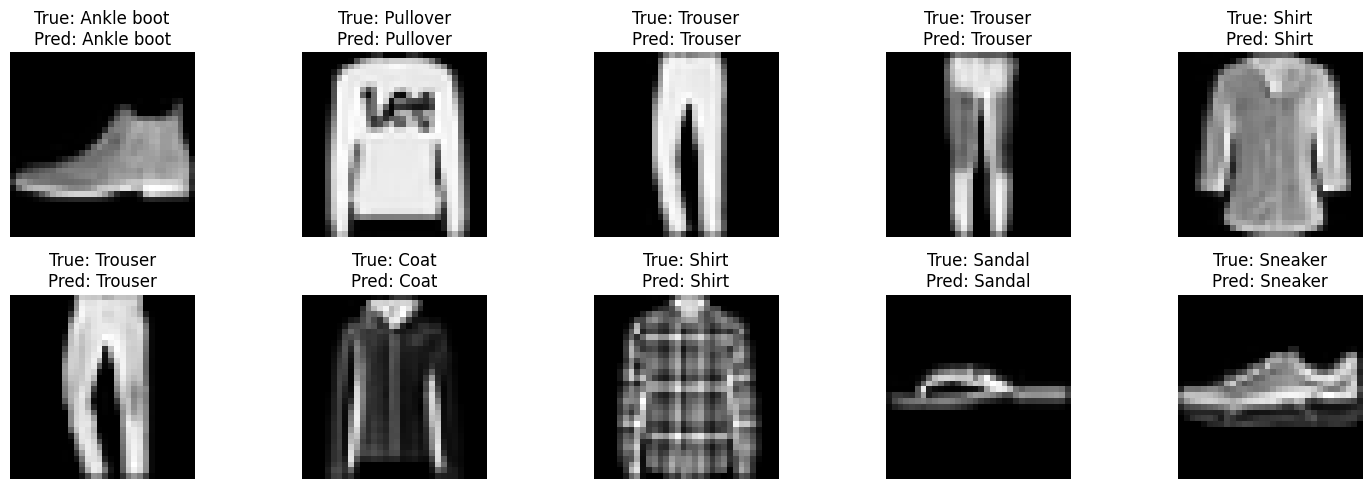

In [21]:
# Example Prediction Visualization
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
example_images = x_test[:10]
example_labels = y_true_classes[:10]
example_preds = y_pred_classes[:10]
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_images[i].reshape(32, 32), cmap='gray')
    plt.title(f"True: {labels[example_labels[i]]}\nPred: {labels[example_preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig("example_predictions.png")
plt.show()


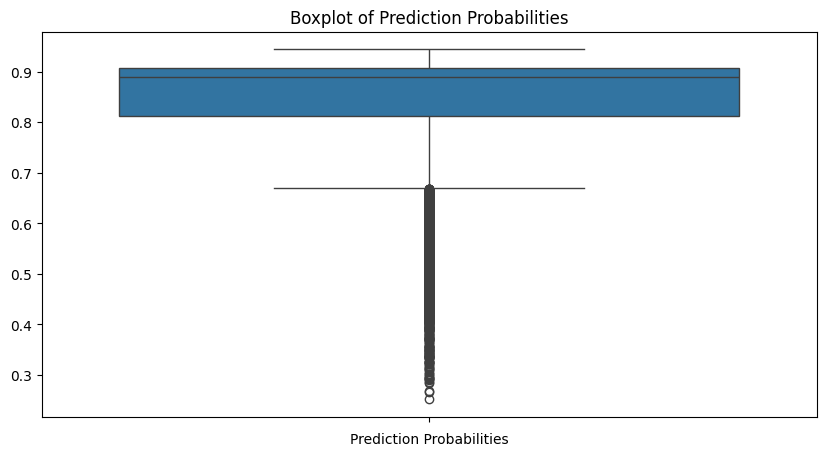

In [22]:
# Boxplot of Prediction Probabilities
probs = np.max(y_pred, axis=1)
plt.figure(figsize=(10, 5))
sns.boxplot(probs)
plt.title("Boxplot of Prediction Probabilities")
plt.xlabel("Prediction Probabilities")
plt.savefig("prediction_probabilities_boxplot.png")
plt.show()